In [34]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

# Guardar modelos
MODELS = os.path.join(PROJECT_ROOT_DIR, "modelos")
os.makedirs(MODELS, exist_ok=True)

# Funciones 

In [35]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    y_limits = (np.min([Y_real.min(), Y_predicted.min()]), np.max([Y_real.max(), Y_predicted.max()]))
    plt.ylim(y_limits)
    #y_limits = (Y_real.min(), Y_real.max())
    #plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r-.", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Comsumption", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (12, 6.75))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("mse")
    plt.grid(True)
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = (12,6.75))

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
        
    plt.plot(train_errors,  "b-.", linewidth=2, label="Training"), # color = "darkorange",
    plt.plot(val_errors, "r-.", linewidth=2, label="Validation")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("mse", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
def plot_weeks(real, predicted, weeks = 1):
    
    Y_real = []
    Y_predicted = []
    
    a = 0
    for i in range(0, 24*7*weeks, 24):
        
        Y_real.extend(real[i])
        Y_predicted.extend(predicted[i])
         
    plt.figure(figsize = (12, 6.75))
    plt.plot(Y_real, label = "predicted")
    plt.plot(Y_predicted, label = "real")
    plt.legend(fontsize=14)
    
    plt.show()

# Importo los datos

In [36]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

# Preparación de los datasets

In [37]:
# Selecciono las columnas para multi step forecasting

df_train = df_train.iloc[:,:].dropna() #todas las columnas, de y + 1 a y + 24
df_test = df_test.iloc[:,:].dropna()

In [38]:
df_train.iloc[:,:]

,total_generation,money_spent,hour,generation_hydro_pumped_storage_consumption,price_actual,generation_solar,generation_fossil_gas,x14_01d,x12_01n,generation_hydro_water_reservoir,...,y + 15,y + 16,y + 17,y + 18,y + 19,y + 20,y + 21,y + 22,y + 23,y + 24
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2.83e+04,1.85e+06,23,8.63e+02,6.54e+01,4.90e+01,4.84e+03,0.00e+00,1.00e+00,1.90e+03,...,2.35e+04,2.31e+04,2.36e+04,2.64e+04,2.80e+04,2.90e+04,2.96e+04,2.90e+04,2.68e+04,2.71e+04
2015-01-01 00:00:00+00:00,2.78e+04,1.81e+06,0,9.20e+02,6.49e+01,5.00e+01,5.20e+03,0.00e+00,1.00e+00,1.66e+03,...,2.31e+04,2.36e+04,2.64e+04,2.80e+04,2.90e+04,2.96e+04,2.90e+04,2.68e+04,2.71e+04,2.49e+04
2015-01-01 01:00:00+00:00,2.68e+04,1.73e+06,1,1.16e+03,6.45e+01,5.00e+01,4.86e+03,0.00e+00,1.00e+00,1.37e+03,...,2.36e+04,2.64e+04,2.80e+04,2.90e+04,2.96e+04,2.90e+04,2.68e+04,2.71e+04,2.49e+04,2.32e+04
2015-01-01 02:00:00+00:00,2.52e+04,1.50e+06,2,1.50e+03,5.93e+01,5.00e+01,4.31e+03,0.00e+00,1.00e+00,7.79e+02,...,2.64e+04,2.80e+04,2.90e+04,2.96e+04,2.90e+04,2.68e+04,2.71e+04,2.49e+04,2.32e+04,2.25e+04
2015-01-01 03:00:00+00:00,2.46e+04,1.38e+06,3,1.83e+03,5.60e+01,4.20e+01,4.13e+03,0.00e+00,1.00e+00,7.20e+02,...,2.80e+04,2.90e+04,2.96e+04,2.90e+04,2.68e+04,2.71e+04,2.49e+04,2.32e+04,2.25e+04,2.21e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-13 13:00:00+00:00,3.27e+04,1.86e+06,13,3.00e+02,5.68e+01,2.82e+03,4.24e+03,0.00e+00,0.00e+00,6.58e+03,...,2.47e+04,2.77e+04,3.12e+04,3.38e+04,3.51e+04,3.56e+04,3.57e+04,3.57e+04,3.54e+04,3.42e+04
2018-03-13 14:00:00+00:00,3.14e+04,1.68e+06,14,3.07e+02,5.35e+01,2.36e+03,4.17e+03,0.00e+00,0.00e+00,5.74e+03,...,2.77e+04,3.12e+04,3.38e+04,3.51e+04,3.56e+04,3.57e+04,3.57e+04,3.54e+04,3.42e+04,3.36e+04
2018-03-13 15:00:00+00:00,3.17e+04,1.76e+06,15,5.99e+02,5.56e+01,1.84e+03,4.59e+03,0.00e+00,0.00e+00,5.80e+03,...,3.12e+04,3.38e+04,3.51e+04,3.56e+04,3.57e+04,3.57e+04,3.54e+04,3.42e+04,3.36e+04,3.31e+04


In [39]:
# Selecciono las columnas

X_Y_train = df_train.to_numpy()
X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-24]
Y_test = X_Y_test[:,-24:]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-24], X_Y_train[:,-24:],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

In [40]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((21020, 14), (21020, 24), (6989, 14), (6989, 24))

In [41]:
# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)

In [42]:
X_Y_train[:,:-24].shape, X_Y_train[:,-24:].shape, X_Y_val[:,:-24].shape, X_Y_val[:,-24:].shape, X_Y_test[:,:-24].shape, X_Y_test[:,-24:].shape

((21020, 14), (21020, 24), (7007, 14), (7007, 24), (6989, 14), (6989, 24))

In [89]:
# Lo convierto en un problema de ML

win_len = 24            # Intento predecir el consumo durante las próximas 24 h, con 24 h de antelación
tamaño_del_batch = 512
number_of_features = 14
separacion = 1

# series

train_ts_generator = TimeseriesGenerator(X_Y_train[:,:-24], X_Y_train[:,-24:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = separacion)

val_ts_generator = TimeseriesGenerator(X_Y_val[:,:-24], X_Y_val[:,-24:], length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = separacion)

test_ts_generator = TimeseriesGenerator(X_Y_test[:,:-24], X_Y_test[:,-24:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = separacion)


# length es el tamaño de la ventana
# sampling_rate es cada cuánto consideramos un dato (1 para datos continuos)
# stride es la separación entre una muestra de train y la siguiente 


print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(train_ts_generator[0][0].shape, train_ts_generator[0][1].shape)

(21020, 14) (21020, 24) (7007, 14) (7007, 24)
(512, 24, 14) (512, 24)


In [69]:
train_ts_generator[0][1][0]

array([0.30926264, 0.25454862, 0.21785497, 0.19787586, 0.18803865,
       0.19630887, 0.19596065, 0.26120832, 0.34347523, 0.4188648 ,
       0.45299034, 0.47183773, 0.49133803, 0.47814921, 0.44380604,
       0.42774441, 0.41842953, 0.41203099, 0.41364151, 0.41512144,
       0.44315313, 0.4431096 , 0.36541308, 0.41107339])

# Modelos de base & tabla de errores

In [70]:
# creo un dataframe para guardar los errores

from sklearn.metrics import mean_squared_error

errores_df = pd.DataFrame()

#naive_train_errors = list()
#naive_val_errors = list()
#naive_test_errors = list()
#
#for i in range(24, len(naive_train.index)):
#    actual = naive_train.iloc[i,:-24].to_numpy()
#    predicted = naive_train.iloc[i,-24:].to_numpy()
#    naive_train_errors.append(mean_squared_error(actual, predicted))
#for i in range(24, len(naive_val.index)):
#    actual = naive_val.iloc[i,:-24].to_numpy()
#    predicted = naive_val.iloc[i,-24:].to_numpy()
#    naive_val_errors.append(mean_squared_error(actual, predicted))
#for i in range(24, len(naive_test.index)):
#    actual = naive_test.iloc[i,:-24].to_numpy()
#    predicted = naive_test.iloc[i,-24:].to_numpy()
#    naive_test_errors.append(mean_squared_error(actual, predicted))
#
#naive_train_errors = np.array(naive_train_errors)
#naive_val_errors   = np.array(naive_val_errors)
#naive_test_errors  = np.array(naive_test_errors)

# El error total del set es la suma (o la media, aún por decidir) de los mse de cada predicción de 24 h

errores_df.loc["naive_1h", "train mse"] = 5.03e+02
errores_df.loc["naive_1h", "val mse"] = 1.61e+02

errores_df.loc["naive_1h", "delta errores"] = np.abs(errores_df.loc["naive_1h", "train mse"]-errores_df.loc["naive_1h", "val mse"])
errores_df.loc["naive_1h", "n params"] = 0
errores_df.loc["naive_1h", "training time (s)"] = np.nan
errores_df.loc["naive_1h", "training prediction time (s)"] = np.nan
errores_df.loc["naive_1h", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
naive_1h,5.03e+02,1.61e+02,3.42e+02,0.00e+00,nan,nan,nan


# Comienzo a probar modelos

### RNN 1

In [90]:
np.random.seed(42)
tf.random.set_seed(42)


rnn_1 = keras.models.Sequential([
    keras.layers.SimpleRNN(96, input_shape = [win_len, number_of_features], return_sequences = True),
    keras.layers.SimpleRNN(48, return_sequences = True),
    keras.layers.SimpleRNN(24,),
    keras.layers.Dense(win_len)                                                      
])

checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "rnn1.h5"), save_best_only = False)

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

rnn_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_rnn_1 = rnn_1.fit(train_ts_generator, epochs = 10, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/10
42/42 [==============================] - 9s 206ms/step - loss: 0.1551 - val_loss: 0.0467
Epoch 2/10
42/42 [==============================] - 8s 200ms/step - loss: 0.0402 - val_loss: 0.0385
Epoch 3/10
42/42 [==============================] - 8s 201ms/step - loss: 0.0368 - val_loss: 0.0354
Epoch 4/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0339 - val_loss: 0.0324
Epoch 5/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0310 - val_loss: 0.0295
Epoch 6/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0282 - val_loss: 0.0267
Epoch 7/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0260 - val_loss: 0.0245
Epoch 8/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0243 - val_loss: 0.0229
Epoch 9/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0230 - val_loss: 0.0217
Epoch 10/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0220 - val_loss: 0.0207

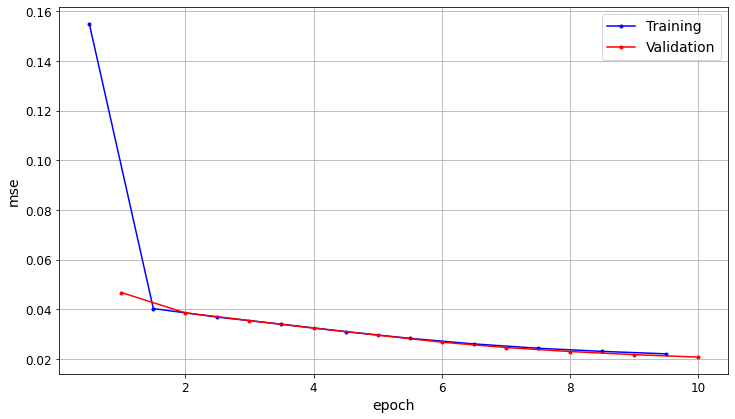

In [91]:
history_rnn_1_df = pd.DataFrame(history_rnn_1.history)


plot_learning_curves(history_rnn_1_df["loss"], history_rnn_1_df["val_loss"])

In [92]:
rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn1.h5"))
                      
history_rnn_2 = rnn_1.fit(train_ts_generator, epochs = 10, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/10
42/42 [==============================] - 9s 206ms/step - loss: 0.0212 - val_loss: 0.0199
Epoch 2/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0204 - val_loss: 0.0192
Epoch 3/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 4/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0192 - val_loss: 0.0181
Epoch 5/10
42/42 [==============================] - 8s 201ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 6/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0182 - val_loss: 0.0171
Epoch 7/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0177 - val_loss: 0.0167
Epoch 8/10
42/42 [==============================] - 8s 201ms/step - loss: 0.0173 - val_loss: 0.0164
Epoch 9/10
42/42 [==============================] - 8s 200ms/step - loss: 0.0169 - val_loss: 0.0160
Epoch 10/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0165 - val_loss: 0.0156

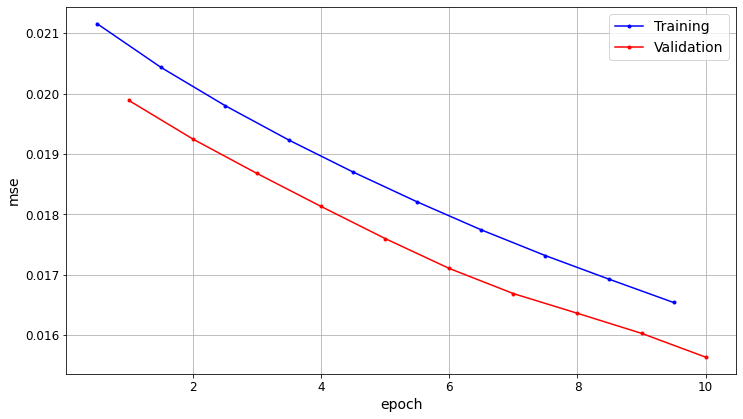

In [93]:
history_rnn_2_df = pd.DataFrame(history_rnn_2.history)


plot_learning_curves(history_rnn_2_df["loss"], history_rnn_2_df["val_loss"])

In [94]:
rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn1.h5"))
                      
history_rnn_3 = rnn_1.fit(train_ts_generator, epochs = 10, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/10
42/42 [==============================] - 9s 207ms/step - loss: 0.0162 - val_loss: 0.0153
Epoch 2/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0158 - val_loss: 0.0149
Epoch 3/10
42/42 [==============================] - 8s 200ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 4/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 5/10
42/42 [==============================] - 8s 201ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 6/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0146 - val_loss: 0.0139
Epoch 7/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0144 - val_loss: 0.0137
Epoch 8/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 9/10
42/42 [==============================] - 8s 200ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 10/10
42/42 [==============================] - 8s 200ms/step - loss: 0.0138 - val_loss: 0.0133

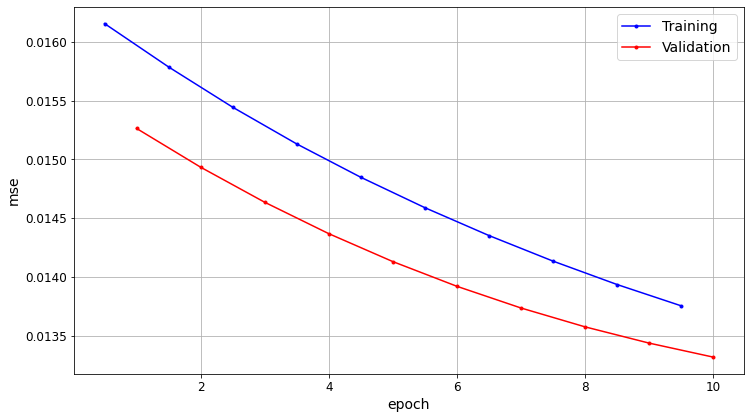

In [95]:
history_rnn_3_df = pd.DataFrame(history_rnn_3.history)


plot_learning_curves(history_rnn_3_df["loss"], history_rnn_3_df["val_loss"])

In [96]:
rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn1.h5"))
                      
history_rnn_4 = rnn_1.fit(train_ts_generator, epochs = 10, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/10
42/42 [==============================] - 9s 206ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 2/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 3/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 4/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 5/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0131 - val_loss: 0.0128
Epoch 6/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 7/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 8/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 9/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0127 - val_loss: 0.0123
Epoch 10/10
42/42 [==============================] - 8s 200ms/step - loss: 0.0127 - val_loss: 0.0122

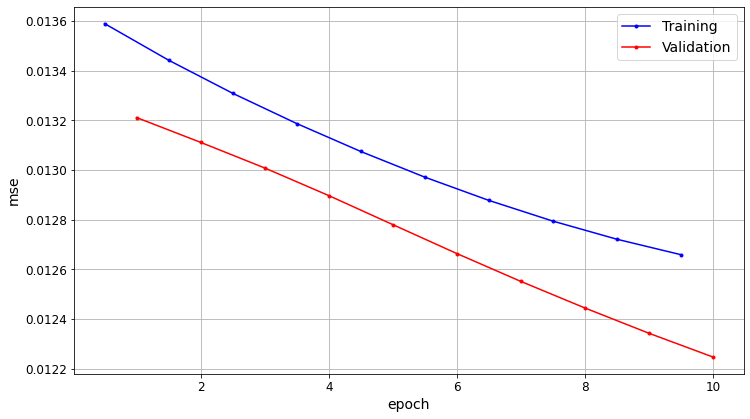

In [97]:
history_rnn_4_df = pd.DataFrame(history_rnn_4.history)


plot_learning_curves(history_rnn_4_df["loss"], history_rnn_4_df["val_loss"])

In [98]:
rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn1.h5"))
                      
history_rnn_5 = rnn_1.fit(train_ts_generator, epochs = 10, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/10
42/42 [==============================] - 9s 206ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 2/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 3/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 4/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 5/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 6/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 7/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 8/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 9/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 10/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0123 - val_loss: 0.0119

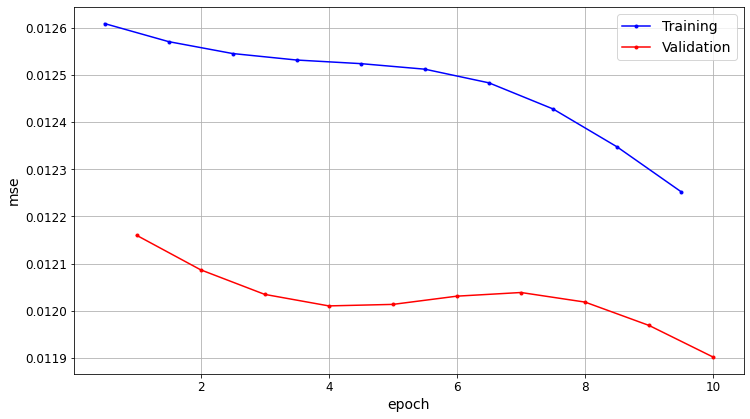

In [99]:
history_rnn_5_df = pd.DataFrame(history_rnn_5.history)


plot_learning_curves(history_rnn_5_df["loss"], history_rnn_5_df["val_loss"])

In [100]:
rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn1.h5"))
                      
history_rnn_6 = rnn_1.fit(train_ts_generator, epochs = 10, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/10
42/42 [==============================] - 9s 205ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 2/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 3/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 4/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 5/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 6/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 7/10
42/42 [==============================] - 8s 197ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 8/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 9/10
42/42 [==============================] - 8s 199ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 10/10
42/42 [==============================] - 8s 198ms/step - loss: 0.0116 - val_loss: 0.0114

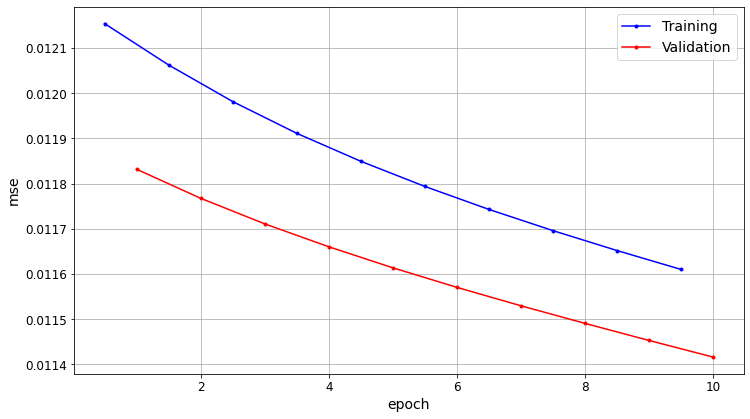

In [101]:
history_rnn_6_df = pd.DataFrame(history_rnn_6.history)


plot_learning_curves(history_rnn_6_df["loss"], history_rnn_6_df["val_loss"])

In [102]:
rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn1.h5"))
                      
history_rnn_7 = rnn_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
42/42 [==============================] - 9s 204ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 2/20
42/42 [==============================] - 8s 198ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 3/20
42/42 [==============================] - 8s 198ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 4/20
42/42 [==============================] - 8s 198ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 5/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 6/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 7/20
42/42 [==============================] - 8s 197ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 8/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 9/20
42/42 [==============================] - 8s 198ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 10/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0113 - val_loss: 0.0111

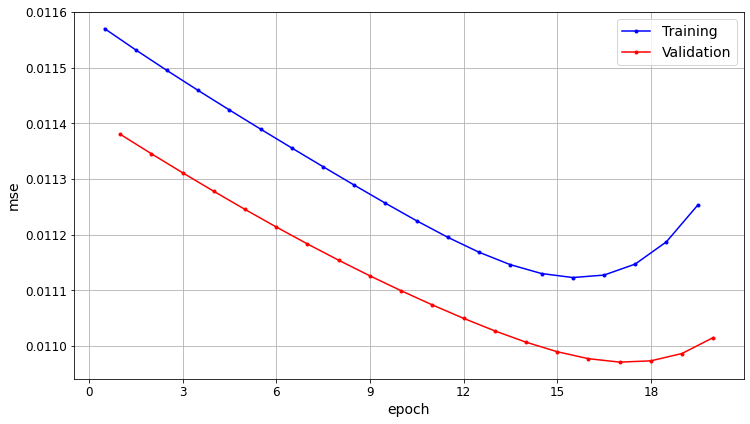

In [103]:
history_rnn_7_df = pd.DataFrame(history_rnn_7.history)


plot_learning_curves(history_rnn_7_df["loss"], history_rnn_7_df["val_loss"])

In [105]:
rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn1.h5"))
                      
history_rnn_8 = rnn_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
42/42 [==============================] - 9s 204ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 2/20
42/42 [==============================] - 8s 198ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 3/20
42/42 [==============================] - 8s 197ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 4/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 5/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/20
42/42 [==============================] - 8s 198ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 7/20
42/42 [==============================] - 8s 198ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 8/20
42/42 [==============================] - 8s 197ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 9/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 10/20
42/42 [==============================] - 8s 199ms/step - loss: 0.0107 - val_loss: 0.0109

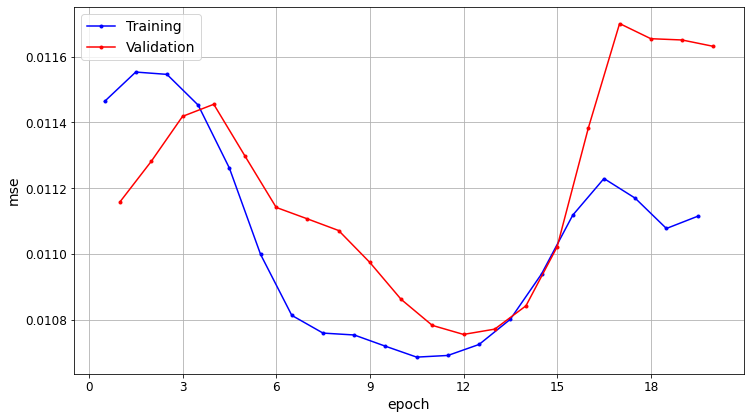

In [106]:
history_rnn_8_df = pd.DataFrame(history_rnn_8.history)


plot_learning_curves(history_rnn_8_df["loss"], history_rnn_8_df["val_loss"])

14/14 [==============================] - 1s 73ms/step - loss: 0.0116
0.01125035248696804 0.011630985885858536


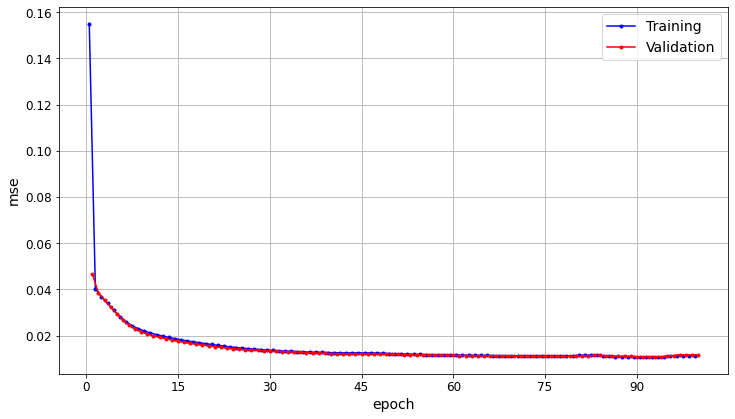

In [115]:
history_rnn_1_df
history_rnn_df = pd.concat([history_rnn_1_df, history_rnn_2_df, history_rnn_3_df, history_rnn_4_df,
                           history_rnn_5_df, history_rnn_6_df, history_rnn_7_df, history_rnn_8_df,
                           ])

print(rnn_1.evaluate(train_ts_generator), rnn_1.evaluate(val_ts_generator))
plot_learning_curves(history_rnn_df["loss"], history_rnn_df["val_loss"])

### RNN 2

In [116]:
np.random.seed(42)
tf.random.set_seed(42)


rnn_2 = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape = [win_len, number_of_features], return_sequences = True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.SimpleRNN(80, return_sequences = True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.SimpleRNN(80, return_sequences = True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.SimpleRNN(80, return_sequences = True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.SimpleRNN(60, return_sequences = True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.SimpleRNN(60, return_sequences = True),
    keras.layers.Dropout(rate=0.2),
    keras.layers.SimpleRNN(40,),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(win_len)                                                      
])

checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "rnn2.h5"), save_best_only = False)

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

rnn_2.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_rnn_2 = rnn_2.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/50
42/42 [==============================] - 28s 671ms/step - loss: 0.3725 - val_loss: 0.0432
Epoch 2/50
42/42 [==============================] - 28s 658ms/step - loss: 0.2327 - val_loss: 0.0345
Epoch 3/50
42/42 [==============================] - 28s 658ms/step - loss: 0.1832 - val_loss: 0.0296
Epoch 4/50
42/42 [==============================] - 28s 659ms/step - loss: 0.1456 - val_loss: 0.0267
Epoch 5/50
42/42 [==============================] - 28s 660ms/step - loss: 0.1157 - val_loss: 0.0255
Epoch 6/50
42/42 [==============================] - 28s 658ms/step - loss: 0.0940 - val_loss: 0.0236
Epoch 7/50
42/42 [==============================] - 28s 657ms/step - loss: 0.0767 - val_loss: 0.0220
Epoch 8/50
42/42 [==============================] - 28s 666ms/step - loss: 0.0641 - val_loss: 0.0212
Epoch 9/50
42/42 [==============================] - 28s 660ms/step - loss: 0.0553 - val_loss: 0.0199
Epoch 10/50
42/42 [==============================] - 28s 664ms/step - loss: 0.0482 - val_lo

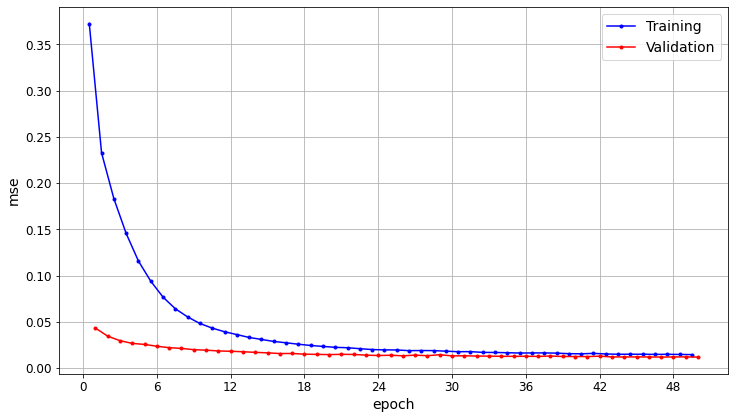

In [117]:
history_rnn_2_df = pd.DataFrame(history_rnn_2.history)


plot_learning_curves(history_rnn_2_df["loss"], history_rnn_2_df["val_loss"])

14/14 [==============================] - 3s 213ms/step - loss: 0.0118
0.011176412925124168 0.011820390820503235


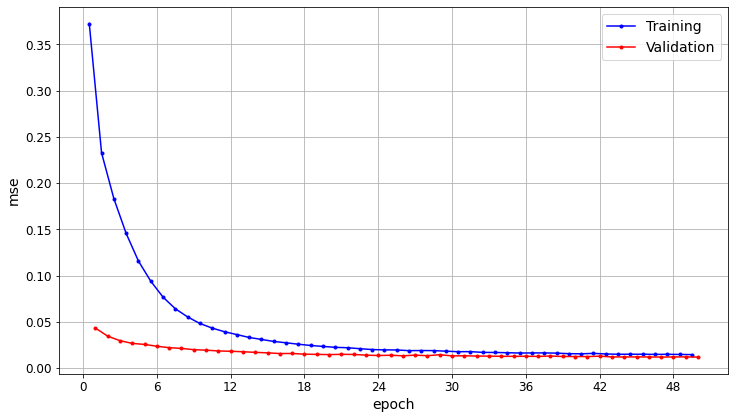

In [120]:
print(rnn_2.evaluate(train_ts_generator), rnn_2.evaluate(val_ts_generator))
plot_learning_curves(history_rnn_2_df["loss"], history_rnn_2_df["val_loss"])

# LSTM

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


lstm_1 = keras.models.Sequential([
        keras.layers.LSTM(96, input_shape=[win_len, number_of_features], return_sequences = True),
        keras.layers.LSTM(48, return_sequences = True),
        keras.layers.LSTM(24,),
        #keras.layers.LSTM(10, input_shape=[None, number_of_features],),# return_sequences = True),
        #keras.layers.TimeDistributed(keras.layers.Dense(24), input_shape=[win_len, number_of_features])
        keras.layers.Dense(win_len)                                                      
])

checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "lstm1.h5"), save_best_only=True)
                                                
early_stopping = keras.callbacks.EarlyStopping(patience = 10)
                                             
lstm_1.compile(loss = "mse", optimizer = "adam")
                      
history_lstm_1 = lstm_1.fit(train_ts_generator, epochs = 30, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/30
42/42 [==============================] - 27s 645ms/step - loss: 0.1130 - val_loss: 0.0448
Epoch 2/30
42/42 [==============================] - 26s 618ms/step - loss: 0.0377 - val_loss: 0.0343
Epoch 3/30
42/42 [==============================] - 26s 621ms/step - loss: 0.0311 - val_loss: 0.0284
Epoch 4/30
42/42 [==============================] - 26s 619ms/step - loss: 0.0254 - val_loss: 0.0242
Epoch 5/30
42/42 [==============================] - 26s 622ms/step - loss: 0.0232 - val_loss: 0.0225
Epoch 6/30
42/42 [==============================] - 26s 622ms/step - loss: 0.0214 - val_loss: 0.0205
Epoch 7/30
42/42 [==============================] - 26s 625ms/step - loss: 0.0200 - val_loss: 0.0194
Epoch 8/30
42/42 [==============================] - 26s 623ms/step - loss: 0.0189 - val_loss: 0.0184
Epoch 9/30
42/42 [==============================] - 26s 622ms/step - loss: 0.0180 - val_loss: 0.0174
Epoch 10/30
42/42 [==============================] - 26s 621ms/step - loss: 0.0170 - val_lo

In [ ]:
history_lstm_1_df = pd.DataFrame(history_lstm_1.history)

plot_learning_curves(history_lstm_1_df["loss"], history_lstm_1_df["val_loss"])

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

lstm_1 = keras.models.load_model(os.path.join(MODELS, "lstm1.h5"))
                      
history_lstm_2 = lstm_1.fit(train_ts_generator, epochs = 30, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/30
21/21 [==============================] - 11s 526ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 2/30
21/21 [==============================] - 10s 460ms/step - loss: 0.0198 - val_loss: 0.0200
Epoch 3/30
21/21 [==============================] - 10s 458ms/step - loss: 0.0194 - val_loss: 0.0197
Epoch 4/30
21/21 [==============================] - 10s 455ms/step - loss: 0.0190 - val_loss: 0.0192
Epoch 5/30
21/21 [==============================] - 10s 456ms/step - loss: 0.0185 - val_loss: 0.0188
Epoch 6/30
21/21 [==============================] - 10s 456ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 7/30
21/21 [==============================] - 10s 457ms/step - loss: 0.0179 - val_loss: 0.0181
Epoch 8/30
21/21 [==============================] - 10s 457ms/step - loss: 0.0176 - val_loss: 0.0178
Epoch 9/30
21/21 [==============================] - 10s 458ms/step - loss: 0.0174 - val_loss: 0.0176
Epoch 10/30
21/21 [==============================] - 10s 458ms/step - loss: 0.0172 - val_lo

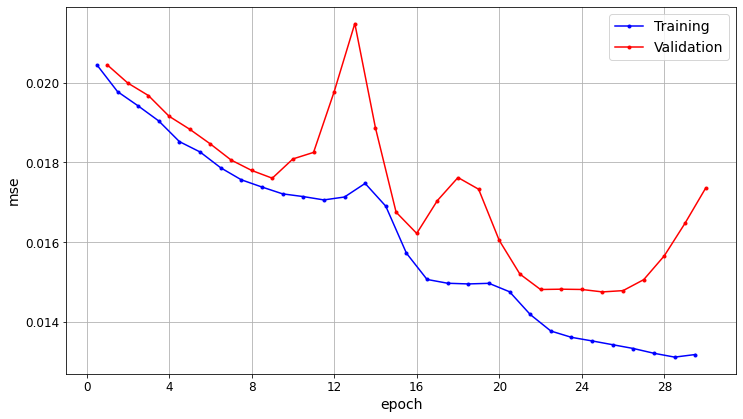

In [82]:
history_lstm_2_df = pd.DataFrame(history_lstm_2.history)

plot_learning_curves(history_lstm_2_df["loss"], history_lstm_2_df["val_loss"])

In [83]:
np.random.seed(42)
tf.random.set_seed(42)

lstm_1 = keras.models.load_model(os.path.join(MODELS, "lstm1.h5"))
                      
history_lstm_3 = lstm_1.fit(train_ts_generator, epochs = 30, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/30
21/21 [==============================] - 11s 522ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 2/30
21/21 [==============================] - 10s 460ms/step - loss: 0.0133 - val_loss: 0.0151
Epoch 3/30
21/21 [==============================] - 10s 459ms/step - loss: 0.0132 - val_loss: 0.0157
Epoch 4/30
21/21 [==============================] - 10s 456ms/step - loss: 0.0131 - val_loss: 0.0165
Epoch 5/30
21/21 [==============================] - 10s 457ms/step - loss: 0.0132 - val_loss: 0.0174
Epoch 6/30
21/21 [==============================] - 10s 458ms/step - loss: 0.0136 - val_loss: 0.0165
Epoch 7/30
21/21 [==============================] - 10s 459ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 8/30
21/21 [==============================] - 10s 460ms/step - loss: 0.0133 - val_loss: 0.0139
Epoch 9/30
21/21 [==============================] - 10s 459ms/step - loss: 0.0128 - val_loss: 0.0141
Epoch 10/30
21/21 [==============================] - 10s 458ms/step - loss: 0.0124 - val_lo

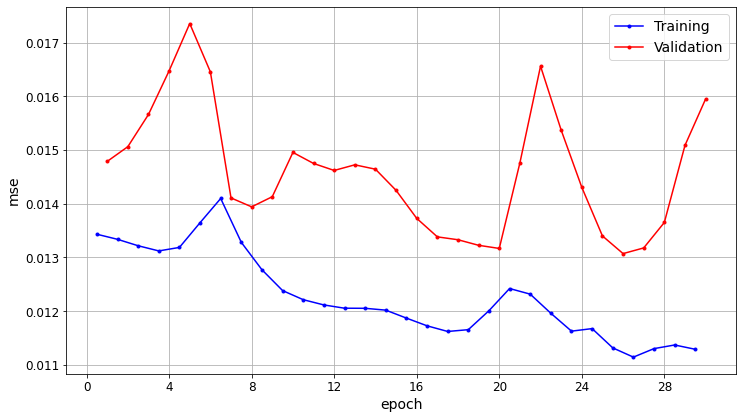

In [84]:
history_lstm_3_df = pd.DataFrame(history_lstm_3.history)

plot_learning_curves(history_lstm_3_df["loss"], history_lstm_3_df["val_loss"])

In [85]:
np.random.seed(42)
tf.random.set_seed(42)

lstm_1 = keras.models.load_model(os.path.join(MODELS, "lstm1.h5"))
                      
history_lstm_4 = lstm_1.fit(train_ts_generator, epochs = 15, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/15
21/21 [==============================] - 11s 525ms/step - loss: 0.0111 - val_loss: 0.0132
Epoch 2/15
21/21 [==============================] - 10s 459ms/step - loss: 0.0113 - val_loss: 0.0137
Epoch 3/15
21/21 [==============================] - 10s 458ms/step - loss: 0.0114 - val_loss: 0.0151
Epoch 4/15
21/21 [==============================] - 10s 458ms/step - loss: 0.0113 - val_loss: 0.0159
Epoch 5/15
21/21 [==============================] - 10s 459ms/step - loss: 0.0113 - val_loss: 0.0152
Epoch 6/15
21/21 [==============================] - 10s 458ms/step - loss: 0.0113 - val_loss: 0.0138
Epoch 7/15
21/21 [==============================] - 10s 457ms/step - loss: 0.0112 - val_loss: 0.0131
Epoch 8/15
21/21 [==============================] - 10s 461ms/step - loss: 0.0109 - val_loss: 0.0130
Epoch 9/15
21/21 [==============================] - 10s 459ms/step - loss: 0.0110 - val_loss: 0.0133
Epoch 10/15
21/21 [==============================] - 10s 458ms/step - loss: 0.0113 - val_lo

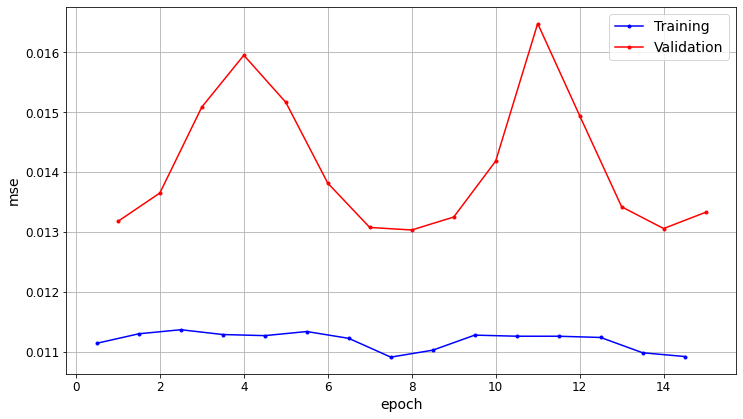

In [86]:
history_lstm_4_df = pd.DataFrame(history_lstm_4.history)

plot_learning_curves(history_lstm_4_df["loss"], history_lstm_4_df["val_loss"])

# GRU 

In [95]:
np.random.seed(42)
tf.random.set_seed(42)


gru_1 = keras.models.Sequential([
    #keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
    #                    input_shape=[None, number_of_features]),
    keras.layers.GRU(24, input_shape=[None, number_of_features], return_sequences=True),
    keras.layers.GRU(24),
    keras.layers.Dense(win_len)
])

checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "gru1.h5"), save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

gru_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_gru_1 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 4s 214ms/step - loss: 0.2003 - val_loss: 0.1330
Epoch 2/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0763 - val_loss: 0.0463
Epoch 3/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0404 - val_loss: 0.0383
Epoch 4/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0372 - val_loss: 0.0360
Epoch 5/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0352 - val_loss: 0.0340
Epoch 6/20
21/21 [==============================] - 4s 189ms/step - loss: 0.0337 - val_loss: 0.0322
Epoch 7/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0322 - val_loss: 0.0306
Epoch 8/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0307 - val_loss: 0.0291
Epoch 9/20
21/21 [==============================] - 4s 191ms/step - loss: 0.0293 - val_loss: 0.0275
Epoch 10/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0280 - val_loss: 0.0261

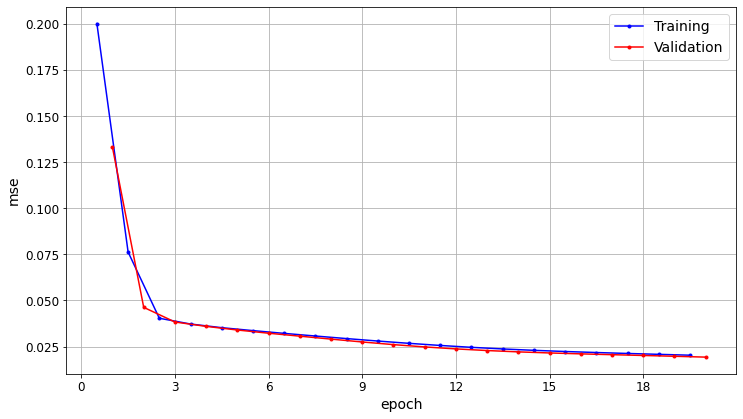

In [96]:
history_gru_1_df = pd.DataFrame(history_gru_1.history)

plot_learning_curves(history_gru_1_df["loss"], history_gru_1_df["val_loss"])

In [97]:
np.random.seed(42)
tf.random.set_seed(42)

gru_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru_2 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 5s 218ms/step - loss: 0.0199 - val_loss: 0.0188
Epoch 2/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0194 - val_loss: 0.0183
Epoch 3/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 4/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0185 - val_loss: 0.0174
Epoch 5/20
21/21 [==============================] - 4s 189ms/step - loss: 0.0180 - val_loss: 0.0170
Epoch 6/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 7/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 8/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 9/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 10/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0159 - val_loss: 0.0155

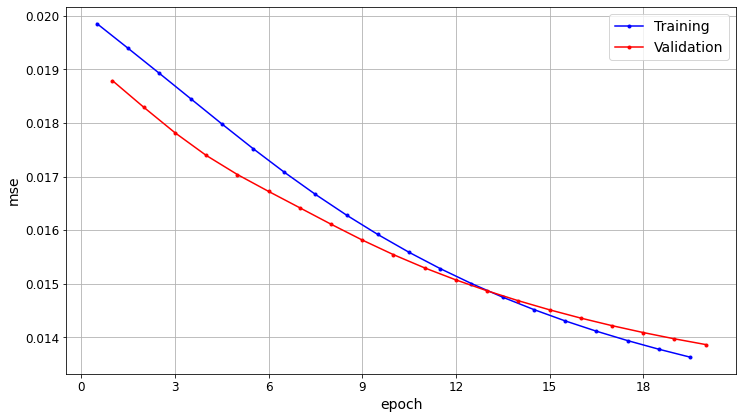

In [98]:
history_gru_2_df = pd.DataFrame(history_gru_2.history)

plot_learning_curves(history_gru_2_df["loss"], history_gru_2_df["val_loss"])

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

gru_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru_3 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 5s 216ms/step - loss: 0.0135 - val_loss: 0.0138
Epoch 2/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 3/20
21/21 [==============================] - 4s 188ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 4/20
21/21 [==============================] - 4s 188ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 5/20
21/21 [==============================] - 4s 189ms/step - loss: 0.0130 - val_loss: 0.0135
Epoch 6/20
21/21 [==============================] - 4s 188ms/step - loss: 0.0129 - val_loss: 0.0134
Epoch 7/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0129 - val_loss: 0.0133
Epoch 8/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0128 - val_loss: 0.0133
Epoch 9/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 10/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0126 - val_loss: 0.0132

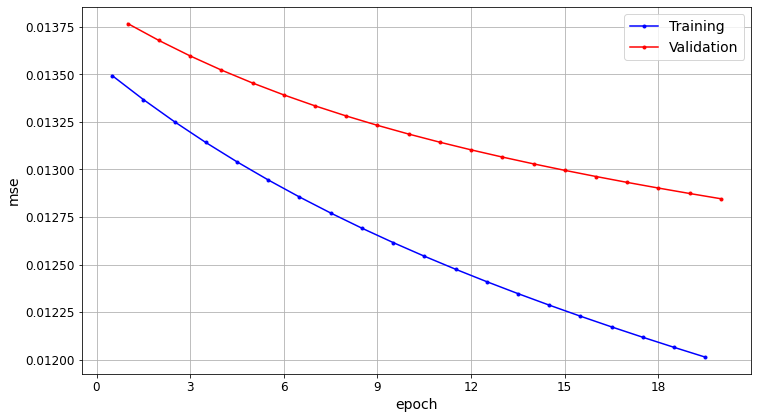

In [100]:
history_gru_3_df = pd.DataFrame(history_gru_3.history)

plot_learning_curves(history_gru_3_df["loss"], history_gru_3_df["val_loss"])

In [101]:
np.random.seed(42)
tf.random.set_seed(42)

gru_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru_4 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 5s 222ms/step - loss: 0.0120 - val_loss: 0.0128
Epoch 2/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0119 - val_loss: 0.0128
Epoch 3/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0119 - val_loss: 0.0128
Epoch 4/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0118 - val_loss: 0.0127
Epoch 5/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0118 - val_loss: 0.0127
Epoch 6/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0117 - val_loss: 0.0127
Epoch 7/20
21/21 [==============================] - 4s 188ms/step - loss: 0.0117 - val_loss: 0.0127
Epoch 8/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0116 - val_loss: 0.0127
Epoch 9/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0116 - val_loss: 0.0126
Epoch 10/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0116 - val_loss: 0.0126

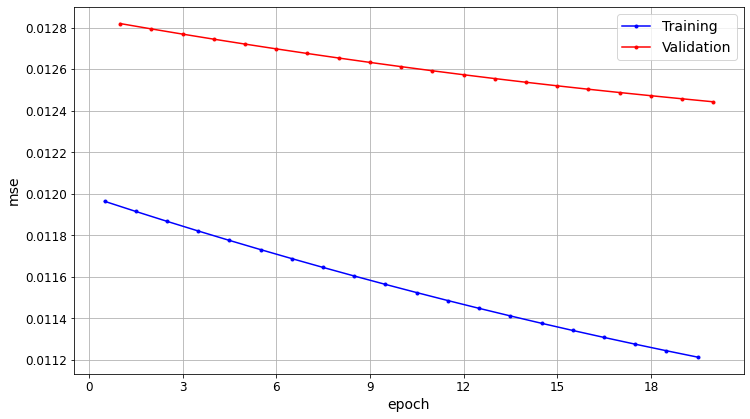

In [102]:
history_gru_4_df = pd.DataFrame(history_gru_4.history)

plot_learning_curves(history_gru_4_df["loss"], history_gru_4_df["val_loss"])

In [103]:
np.random.seed(42)
tf.random.set_seed(42)

gru_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru_5 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 5s 216ms/step - loss: 0.0112 - val_loss: 0.0124
Epoch 2/20
21/21 [==============================] - 4s 188ms/step - loss: 0.0112 - val_loss: 0.0124
Epoch 3/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 4/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 5/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 6/20
21/21 [==============================] - 4s 189ms/step - loss: 0.0110 - val_loss: 0.0124
Epoch 7/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0110 - val_loss: 0.0123
Epoch 8/20
21/21 [==============================] - 4s 183ms/step - loss: 0.0110 - val_loss: 0.0123
Epoch 9/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0110 - val_loss: 0.0123
Epoch 10/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0109 - val_loss: 0.0123

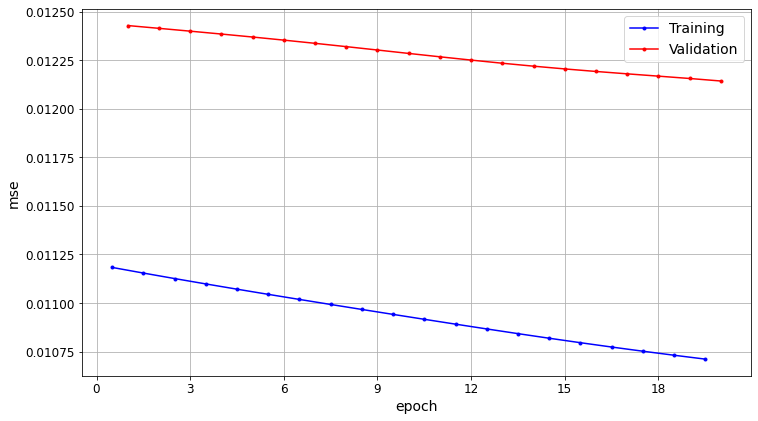

In [104]:
history_gru_5_df = pd.DataFrame(history_gru_5.history)

plot_learning_curves(history_gru_5_df["loss"], history_gru_5_df["val_loss"])

In [105]:
np.random.seed(42)
tf.random.set_seed(42)

gru_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru_6 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 5s 219ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 2/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 3/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0107 - val_loss: 0.0121
Epoch 4/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 5/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0106 - val_loss: 0.0120
Epoch 6/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0106 - val_loss: 0.0120
Epoch 7/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0106 - val_loss: 0.0120
Epoch 8/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 9/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 10/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0105 - val_loss: 0.0119

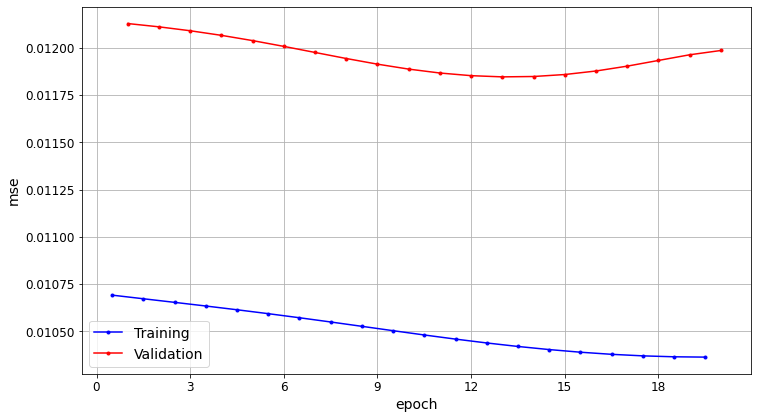

In [106]:
history_gru_6_df = pd.DataFrame(history_gru_6.history)

plot_learning_curves(history_gru_6_df["loss"], history_gru_6_df["val_loss"])

In [107]:
np.random.seed(42)
tf.random.set_seed(42)

gru_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru_7 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 5s 219ms/step - loss: 0.0104 - val_loss: 0.0118
Epoch 2/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0104 - val_loss: 0.0119
Epoch 3/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0104 - val_loss: 0.0119
Epoch 4/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0104 - val_loss: 0.0119
Epoch 5/20
21/21 [==============================] - 4s 183ms/step - loss: 0.0104 - val_loss: 0.0119
Epoch 6/20
21/21 [==============================] - 4s 182ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 7/20
21/21 [==============================] - 4s 183ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 8/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 9/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 10/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0104 - val_loss: 0.0119

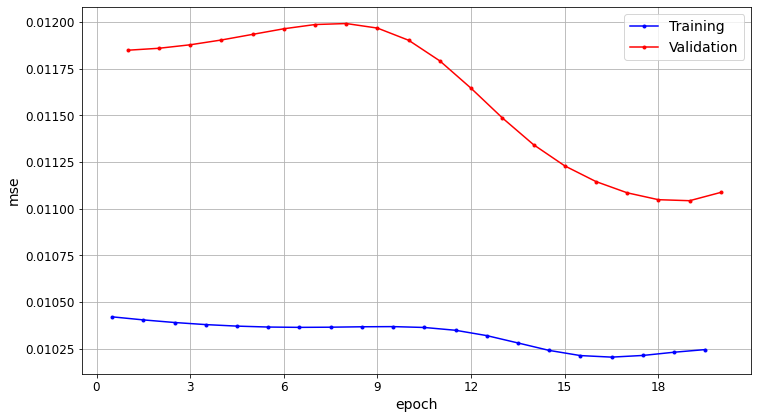

In [108]:
history_gru_7_df = pd.DataFrame(history_gru_7.history)

plot_learning_curves(history_gru_7_df["loss"], history_gru_7_df["val_loss"])

In [109]:
np.random.seed(42)
tf.random.set_seed(42)

gru_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru_8 = gru_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 5s 240ms/step - loss: 0.0102 - val_loss: 0.0111
Epoch 2/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0102 - val_loss: 0.0112
Epoch 3/20
21/21 [==============================] - 4s 185ms/step - loss: 0.0102 - val_loss: 0.0114
Epoch 4/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0102 - val_loss: 0.0117
Epoch 5/20
21/21 [==============================] - 4s 181ms/step - loss: 0.0101 - val_loss: 0.0121
Epoch 6/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0102 - val_loss: 0.0125
Epoch 7/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0103 - val_loss: 0.0126
Epoch 8/20
21/21 [==============================] - 4s 184ms/step - loss: 0.0106 - val_loss: 0.0119
Epoch 9/20
21/21 [==============================] - 4s 188ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 10/20
21/21 [==============================] - 4s 187ms/step - loss: 0.0106 - val_loss: 0.0109

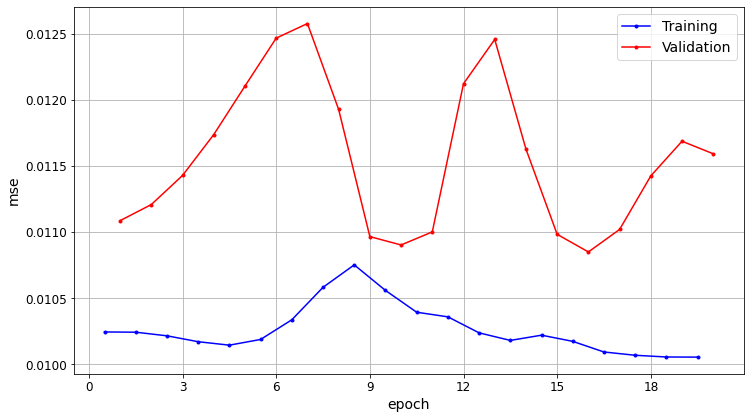

In [110]:
history_gru_8_df = pd.DataFrame(history_gru_8.history)

plot_learning_curves(history_gru_8_df["loss"], history_gru_8_df["val_loss"])

In [113]:
print(gru_1.evaluate(train_ts_generator), gru_1.evaluate(val_ts_generator))

7/7 [==============================] - 0s 62ms/step - loss: 0.0116
0.01023639552295208 0.011592376977205276


In [19]:
Y_val_predicted = gru_1.predict(val_ts_generator)

df_val_predicted = pd.concat([pd.DataFrame(X_val[24:,:]), pd.DataFrame(Y_val_predicted)], axis = 1)
#train_df_predicted = train_df_predicted.set_index(df_train.index[24:])
#df_train_real = pd.concat([pd.DataFrame(X_train[:,:]), pd.DataFrame(Y_train[:])], axis = 1)

# Para des - esclar los datos

#X_Y_train_predicted = scaler.inverse_transform(df_train_predicted)
#X_Y_train_real = scaler.inverse_transform(df_train_real)
#
#df_train_predicted = pd.concat([pd.DataFrame(X_Y_train_predicted[:,:-24]), pd.DataFrame(X_Y_train_predicted[:, -24:])], axis = 1)
#df_train_real = df_train.iloc[24:21020,:]
#df_train_real = pd.concat([pd.DataFrame(X_Y_train_real[24:,:-24]), pd.DataFrame(X_Y_train_real[24:, -24:])], axis = 1)

NameError: name 'gru_1' is not defined

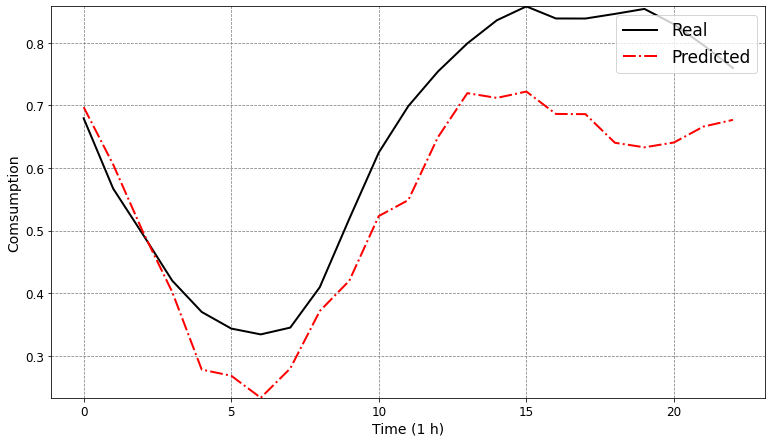

In [119]:
offset = 24

plot_real_vs_predicted(X_Y_val[offset*19,-24:], df_val_predicted.iloc[24*18,-24:].to_numpy(), x_limits = (0,-1))

# GRU 2

In [13]:
np.random.seed(42)
tf.random.set_seed(42)


gru2_1 = keras.models.Sequential([
    #keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
    #                    input_shape=[None, number_of_features]),
    keras.layers.GRU(50, input_shape=[None, number_of_features], return_sequences=True),
    keras.layers.GRU(24, return_sequences=True),
    keras.layers.GRU(24, return_sequences=True),
    keras.layers.GRU(24),
    keras.layers.Dense(win_len)
])

checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "gru2.h5"), save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

gru2_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_gru2_1 = gru2_1.fit(train_ts_generator, epochs = 100, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/100
21/21 [==============================] - 11s 541ms/step - loss: 0.1411 - val_loss: 0.0688
Epoch 2/100
21/21 [==============================] - 10s 483ms/step - loss: 0.0478 - val_loss: 0.0403
Epoch 3/100
21/21 [==============================] - 10s 479ms/step - loss: 0.0380 - val_loss: 0.0380
Epoch 4/100
21/21 [==============================] - 10s 478ms/step - loss: 0.0359 - val_loss: 0.0349
Epoch 5/100
21/21 [==============================] - 10s 478ms/step - loss: 0.0331 - val_loss: 0.0316
Epoch 6/100
21/21 [==============================] - 10s 480ms/step - loss: 0.0304 - val_loss: 0.0291
Epoch 7/100
21/21 [==============================] - 10s 479ms/step - loss: 0.0279 - val_loss: 0.0271
Epoch 8/100
21/21 [==============================] - 10s 478ms/step - loss: 0.0255 - val_loss: 0.0246
Epoch 9/100
21/21 [==============================] - 10s 478ms/step - loss: 0.0234 - val_loss: 0.0227
Epoch 10/100
21/21 [==============================] - 10s 481ms/step - loss: 0.021

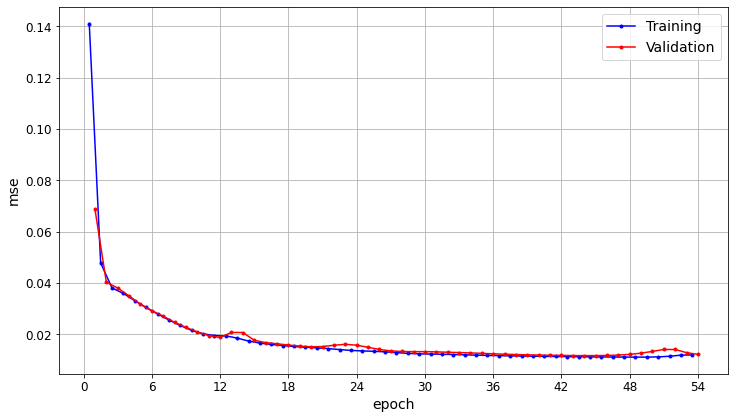

In [14]:
history_gru2_1_df = pd.DataFrame(history_gru2_1.history)

plot_learning_curves(history_gru2_1_df["loss"], history_gru2_1_df["val_loss"])

In [16]:
Y_val_predicted = gru2_1.predict(val_ts_generator)

df_val_predicted = pd.concat([pd.DataFrame(X_val[24:,:]), pd.DataFrame(Y_val_predicted)], axis = 1)
#train_df_predicted = train_df_predicted.set_index(df_train.index[24:])
#df_train_real = pd.concat([pd.DataFrame(X_train[:,:]), pd.DataFrame(Y_train[:])], axis = 1)

# Para des - esclar los datos

#X_Y_train_predicted = scaler.inverse_transform(df_train_predicted)
#X_Y_train_real = scaler.inverse_transform(df_train_real)
#
#df_train_predicted = pd.concat([pd.DataFrame(X_Y_train_predicted[:,:-24]), pd.DataFrame(X_Y_train_predicted[:, -24:])], axis = 1)
#df_train_real = df_train.iloc[24:21020,:]
#df_train_real = pd.concat([pd.DataFrame(X_Y_train_real[24:,:-24]), pd.DataFrame(X_Y_train_real[24:, -24:])], axis = 1)

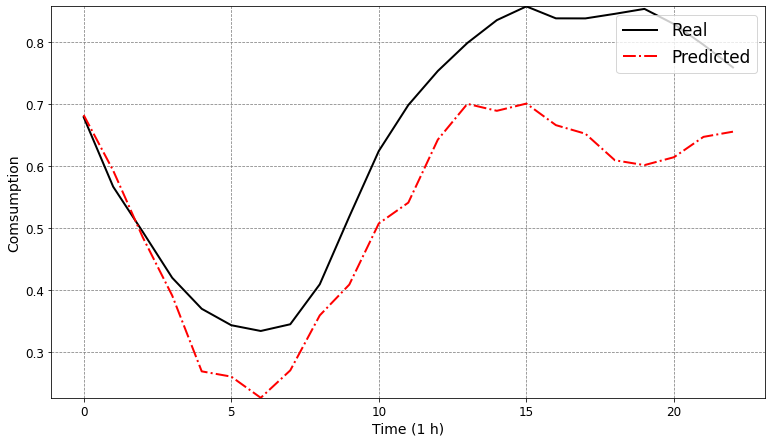

In [20]:
offset = 24

plot_real_vs_predicted(X_Y_val[offset*19,-24:], df_val_predicted.iloc[24*18,-24:].to_numpy(), x_limits = (0,-1))

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

gru2_1 = keras.models.load_model(os.path.join(MODELS, "gru1.h5"))
                      
history_gru2_2 = gru2_1.fit(train_ts_generator, epochs = 20, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint])

Epoch 1/20
21/21 [==============================] - 4s 214ms/step - loss: 0.0101 - val_loss: 0.0110
Epoch 2/20
21/21 [==============================] - 4s 181ms/step - loss: 0.0101 - val_loss: 0.0114
Epoch 3/20
21/21 [==============================] - 4s 182ms/step - loss: 0.0101 - val_loss: 0.0117
Epoch 4/20
21/21 [==============================] - 4s 183ms/step - loss: 0.0101 - val_loss: 0.0116
Epoch 5/20
 1/21 [>.............................] - ETA: 0s - loss: 0.0118

KeyboardInterrupt: 